# Turbine Thermal Analysis

> Date: 31/05/2025

> Author: Elias Aoubala 

In [2]:
import cantera as ct
import numpy as np
import handcalcs.render

## 1 - Background

Based on the recent mechanical design review, it was identified that a larger blade profiling would be requried for manufacturing to be sufficient.

This had resulted in a signficantly thicker blade which are likely to deviate ROSS results significantly. Thus this document aims to re-evaluate the requirements for the thickness by performing a more indepth thermal analysis and get an idea of what the thermal transient on the blade will look like.

## 2 - Review of Relevant Litterature

### 2.1 - Temperatue Effects on Material

Key to this analysis is an understanding of what the yield stress will look like at elevated temperatures. 
The baseline material for the turbine is SS304.
We can refer to the yield stress temeprature dependency curve for 304 from MMPDS.

The most dominant stress direction that is relevant for our application is tensile stresses, so we can model for that accordingly.

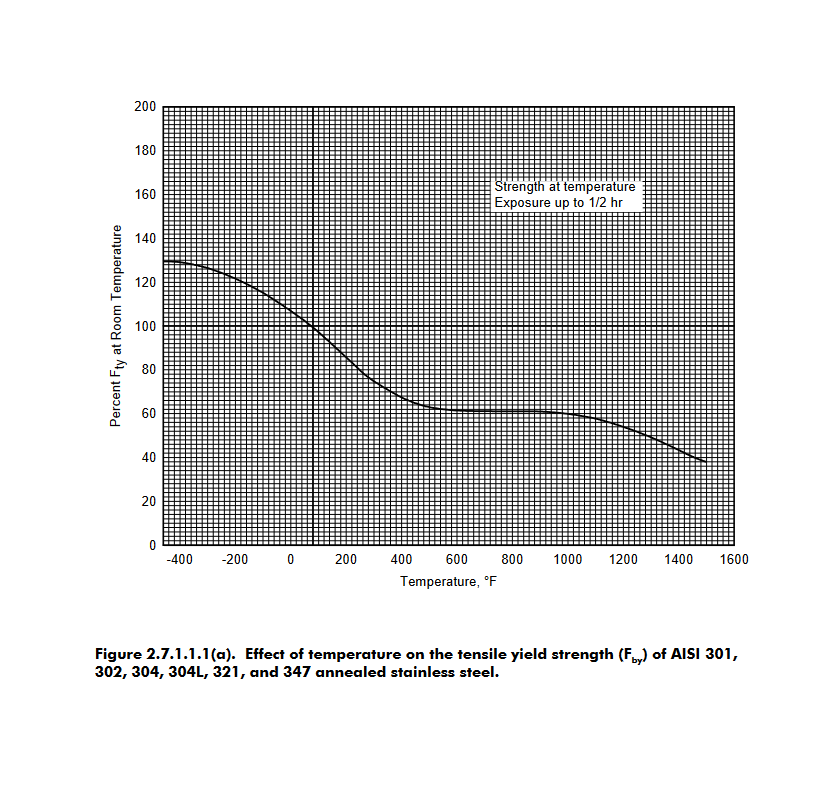

For the tensile ultimate stress, we can look at the following plot also:

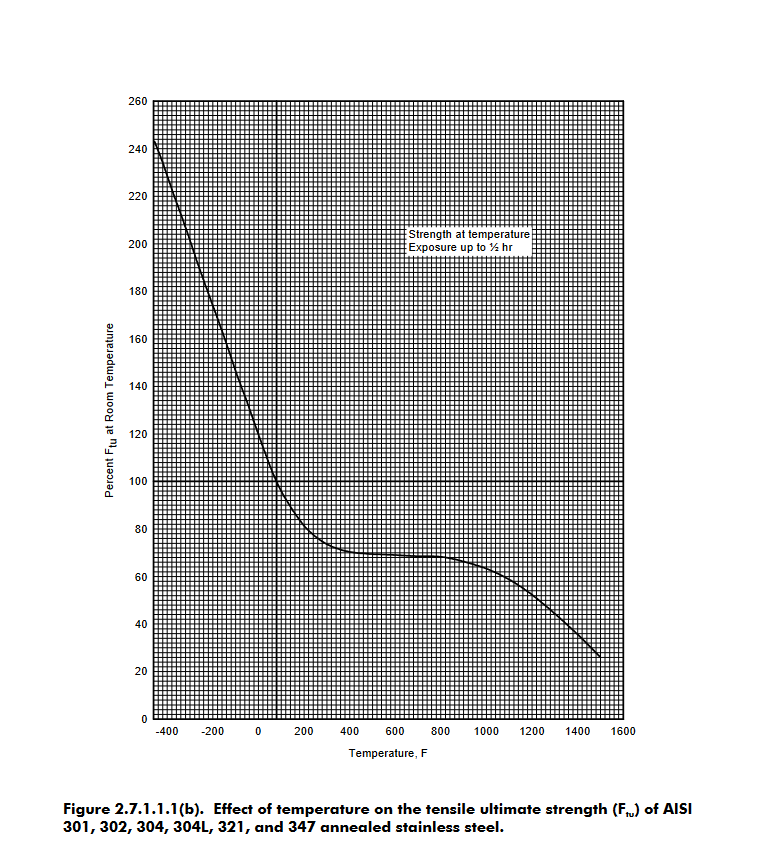

### 2.2 - Heat Transfer Coefficient Estimation

Inorder to conduct this transient heat transfer analysis, we need to be able to quantify what the heat transfer coefficient of the gas will be on the turbine walls.

This is a challenging analysis, as the flow dynamics are complex, however we can get a "order of magnitude" estimate by using the Dittus-Boelter equation which is as follows:

$$Nu_{D} = 0.023 Re^{4/5} Pr^{n}$$

We will evaluate for the reynolds number and prantl number of the gas at the turbine entrance to define our associated Nusselt Number.

We will use cantera to define our combustion conditions, assuming they are frozen fromt he chamber and the nozzle up until turbine entry.

Prandtl number is defined as the following:

$$Pr = \frac{c_p \mu}{k}$$

Reynolds Number of the flow will be defined based on the exit nozzle area of the gas, assuming no expansion is occuring beyond the nozzle, with the exit mach number being maintained.

As our cantera mechanism file is limited, we will use CEA to give us an idea of our Prandtl number - however this will be changed in future.


#### 2.2.1 - Combustion Modelling for Thermodynamic Properties.

We define our propellants for the combustion modelling, along with the mechanism file for it.

In [20]:
%%render

fuel = "C3H8O,2propanol"
oxidiser = "N2O"
MR = 1
T_init = 295
P_c = 25e5
species_file = "nasa_gas.yaml"

<IPython.core.display.Latex object>

In [21]:
full_species = ct.Species.list_from_file(species_file)

molecules = []

for species in full_species:

    if species.name == fuel:
        fu_present = True

        comp = species.composition

        molecules += comp

    elif species.name == oxidiser:
        ox_present = True

        comp = species.composition

        molecules += comp

specific = []
for species in full_species:

    comp = species.composition

    # we get the keys
    if not any(item not in molecules for item in comp.keys()):
        specific.append(species)

gas = ct.Solution(thermo="ideal-gas", species=specific)
gcr = ct.Solution("graphite.yaml")

mix_phases = [(gas, 1.0), (gcr, 0.0)]

We can now run our analysis and get our key thermodynamic properties

In [55]:
gas.Y = {fuel: 1, oxidiser: MR}
mix = ct.Mixture(mix_phases)

mix.T = T_init
mix.P = P_c
mix.equilibrate("HP")

print(gas.density)

T_final = gas.T

# We can then our key properties
cp = gas.cp_mass
R = ct.gas_constant / gas.mean_molecular_weight

print(R)

gamma = gas.cp_mass / gas.cv_mass

print(P_c/(R*T_final))

4.124474755508891
504.4040593276217
4.124474755508891


We can use these to get the velocity of the gas at inlet conditions

In [59]:
%%render

c = (gamma * R* T_final*0.85**2)**(1/2)

<IPython.core.display.Latex object>

Prantl Number and viscosity:

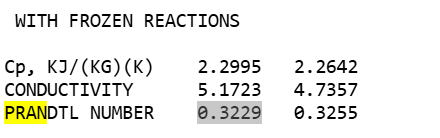

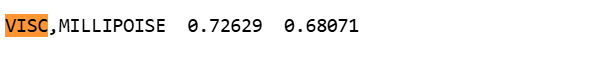

From here, we can sovle for our reynolds number based on the velocity, pressure and temperature of the gas entering the turbine.

This will be extracted from the `turbine_design.ipynb` document.

In [38]:
%%render sci_not

p_1 = 1.92e5
t_1 = 592.8

c_1 = 1110.6469
d_1 = 5.16e-3

mu = 0.72629e-4
k = 4e-1
Pr = 0.3229


<IPython.core.display.Latex object>

Calculating our parameters:

In [52]:
%%render

rho_1 = p_1 / (R * t_1)

Re = (rho_1 * c_1 * d_1) / mu

<IPython.core.display.Latex object>

We can then calculate our Nusselt Number accordingly.

In [41]:
%%render

Nu = 0.023 * Re**(4/5) * Pr**0.3

<IPython.core.display.Latex object>

From here we can solve for our heat transfer coefficient of the gas.

In [43]:
%%render

h = (Nu * k)/d_1

<IPython.core.display.Latex object>

We can then input these conditions into our solver!

## 3 - Thermal Results